# Noise Power Spectra

### Method:

1. Run 21cmSense for HERA-350 array configuration in the 2D case
2. Calculate the sensitivity of a SPHEREx measurement at the same redshift with the window function for the 2D case.
3. Use the equation below to calculate the 2D noise power spectrum and use the averaging function in 21cmSense to average down to a 1D power spectrum

$$\sigma_{21,{\rm Ly}\alpha}^2 \left(k, \mu \right) = \frac{1}{2}\left[ P_{21,{\rm Ly}\alpha}^2 \left(k, \mu \right) + \sigma_{21} \left(k, \mu \right) \sigma_{\rm Ly \alpha} \left(k, \mu \right) \right]$$

4. Make plots of the each noise contribution to the cross-power spectrum (i.e. 21cm thermal noise, Ly$\alpha$ thermal noise w/ window function, cosmic variance, etc.) 

### More Specific Method

1. Calculate 2D noise power spectrum for 21cm with 21cmSense
2. Calculate the 2D noise power spectrum for Ly$\alpha$ using Powerbox and window function equation
3. Interpolate Ly$\alpha$ noise power spectrum onto 21cm grid
4. Calculate the 2D cross-power spectrum using Powerbox and interpolate onto 21cm grid
5. Convert to proper units (mK$^2$)
5. Add and average into a 1D noise power spectrum

In [1]:
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
from astropy.cosmology import Planck15 as cosmo
from twentyonecmFAST import load_binary_data
from powerbox import get_power
from astropy import constants as const
import xcorr
import sys
import pickle
import os
import glob
from py21cmsense import sensitivity as sense

## 21cm Noise Auto Spectrum

Reasonable estimates for HERA: $B = 8 \ {\rm MHz}$, $t_{\rm int} = 1000 \ {\rm hr}$

In [2]:
c = 3e8 * u.m / u.second

In [3]:
"""

Parallel Mode Resolution

"""

def k_par_res(z, R_res = 41.5):
    """k parallel mode resolution for SPHEREx
    """
    return 2 * np.pi * (R_res * cosmo.H(z) / (c * (1 + z))).to(u.Mpc ** -1)


"""

Perpendicular Mode Resolution

"""

def k_perp_res(z, x_pix = 6.2 * u.arcsecond):
    """Perpendicular Resolution for 
    """
    theta = x_pix.to(u.radian)
    return 2 * np.pi / (cosmo.comoving_distance(z) * theta)


"""

Window Function to Introduce Resolution Error to SPHEREx

"""

def W(kperp, kpar, z):
    """Window function to handle resolution limitations of SPHEREx
    
    Parameters
    ----------
    kperp: float
    kpar: float 
    z: float
    
    Returns:
    
    
    """
    kpar_res = k_par_res(z).value
    kperp_res = k_perp_res(z).value
    return np.exp((kperp / kperp_res) ** 2 + (kpar / kpar_res) ** 2)

## Ly$\alpha$ Noise Auto Spectrum

$$\sigma_{\rm Ly\alpha} \left(k, \mu \right) = P_{\rm Ly\alpha} \left( k, \mu \right) + \sigma_{N} V_{\rm pix} W \left( k, \mu \right)$$

## 21cm-Ly$\alpha$ Cross-Power Spectrum Variance

In [4]:
z = 6

In [5]:
temp_21 = load_binary_data('../../data/delta_T_v3_z006.00_nf0.025588_useTs1_256_200Mpc')
temp_21 = np.reshape(temp_21, (256,256,256))

In [6]:
ps, k = xcorr.dimensional_ps(temp_21, 200, log_bins = True, bins = 14)

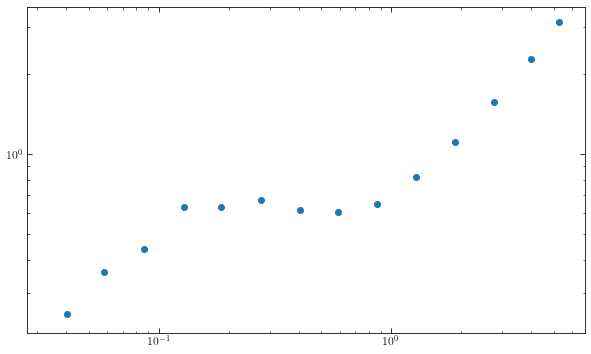

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(k, ps)
plt.xscale('log')
plt.yscale('log')
plt.show()

## Lyman-alpha Power Spectra

In [8]:
z = 7.04
halos = np.loadtxt('../../data/halos_z7.04_768_200Mpc')
halo_pos = (halos[:, 1:] * 256).astype(int)
halo_mass = halos[:, 0]

lya_cube = xcorr.cube_brightness(halo_mass, halo_pos, z)

In [9]:
ps, k = xcorr.dimensional_ps(lya_cube, 200, bins = 14, log_bins = True)
ps_interp = interp1d(k, ps)

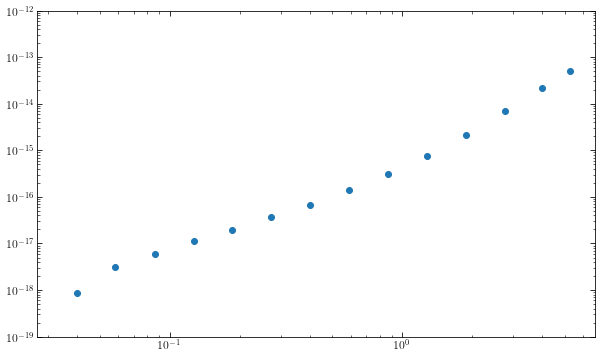

In [10]:
plt.figure(figsize = (10, 6))
plt.scatter(k, ps)
plt.plot(k, ps, alpha = 0)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-19, 1e-12])
plt.show()

In [11]:
dT_7 = load_binary_data('../../data/delta_T_v3_z007.04_nf0.233584_useTs1_256_200Mpc')
dT_7 = np.reshape(dT_7, (256, 256, 256))
xps, xk = xcorr.dimensional_ps(dT_7 * xcorr.mK_to_SB(1 * u.mK, z = 7.04).value, 200, 
                               deltax2 = lya_cube,  bins = 14, log_bins = True)

xps_interp = interp1d(xk, xps)

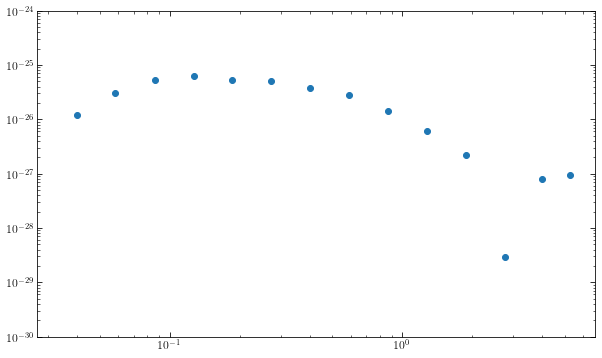

In [12]:
plt.figure(figsize = (10,6))
plt.scatter(xk, np.abs(xps))
plt.plot(xk, np.abs(xps), alpha = 0)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,1e-24])
plt.show()

In [13]:
def V_pix(z, x_pix = 6.2 * u.arcsecond):
    """
    """
    return ((cosmo.kpc_comoving_per_arcmin(z) * x_pix) ** 2 / k_par_res(z)).to(u.Mpc ** 3)

In [14]:
def lyman_noise(ps_interp, kperp, kpar, z, thermal = True, sample = True,
                thermal_noise = 3e-20):
    """
    Noise contribution from SPHEREx-like experiment
    """
    k = np.sqrt(kperp ** 2 + kpar ** 2)
    var = 0
    if sample:
        try:
            var += ps_interp(k)
        except ValueError:
            return np.inf
    
    if thermal:
        var += k ** 3 / (2 * np.pi ** 2) * W(kperp, kpar, z) * V_pix(z).value * thermal_noise ** 2
        
    return var

def x_var(kperp, kpar, pspec = xps_interp):
    """
    """
    k = np.sqrt(kperp ** 2 + kpar ** 2)
    try:
        return pspec(k)
    except ValueError:
        return np.inf
    return 

def x_power_spec(ks):
    """
    """
    ps = []
    for k in ks:
        try:
            ps.append(xps_interp(k))
        except ValueError:
            ps.append(np.inf)
    return np.array(ps)

## 21cmSense

### No Wedge

In [40]:
sensitivity = sense.PowerSpectrum.from_yaml('../sense_configs/hera_sense_opt_7.yml')
sample_mod = sensitivity.calculate_sensitivity_2d(sample = True, thermal = True)

calculating 2D sensitivity:   0%|          | 0/220 [00:00<?, ?uv-bins/s]/usr/local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
calculating 2D sensitivity: 100%|██████████| 220/220 [00:21<00:00, 10.30uv-bins/s]


In [41]:
final_sense = sample_mod.copy()

In [42]:
for i, k_perp in enumerate(sample_mod.keys()):
    for j, k_par in enumerate(sensitivity.observation.kparallel):
        """
        if k_par.value < 0.06:
            lya_n = lyman_noise(ps_interp, k_perp.value, k_par.value, z = 7., thermal = True)
        else:
            lya_n = 1.
        """
        lya_n = lyman_noise(ps_interp, k_perp.value, k_par.value, z = 7., thermal = True) # Units: (ergs / cm^2 / sr / Hz)^2
        radio_n = sample_mod[k_perp][j].value * xcorr.mK_to_SB(1 * u.mK, z = 7.).value ** 2  # Units: (ergs / cm^2 / sr / Hz)^2
        final_sense[k_perp][j] = np.sqrt((x_var(k_perp, k_par) ** 2 + lya_n * radio_n) / 2.0) * u.mK ** 2 # Units: (ergs / cm^2 / sr / Hz)^2
        

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp


In [43]:
x_noise = sensitivity._average_sense_to_1d(final_sense)

averaging to 1D: 100%|██████████| 175/175 [00:06<00:00, 24.59kpar bins/s]
/usr/local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [44]:
ks = np.logspace(np.log10(sensitivity.k1d.min().value), np.log10(sensitivity.k1d.max().value), 100)
err_x = interp1d(sensitivity.k1d, x_noise, kind = 'linear')
cross_noise = err_x(ks)
cross_noise[np.isinf(cross_noise)] = 1e5
cross_noise[np.isnan(cross_noise)] = 1e5

Text(0, 0.5, ' $|\\Delta_{21, \\rm Ly\\alpha} | \\left[ {\\rm erg \\ s^{-1} \\ cm^{-2} \\ sr^{-1}}\\right]^2$')

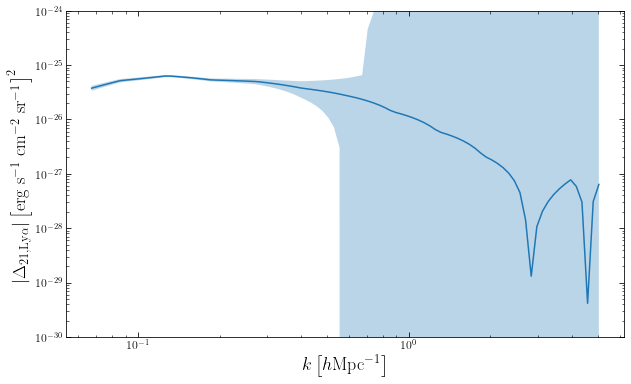

In [46]:
plt.figure(figsize = (10, 6))
plt.plot(ks, np.abs(x_power_spec(ks)))
plt.fill_between(ks, np.abs(x_power_spec(ks)) - cross_noise,
                 np.abs(x_power_spec(ks)) + cross_noise, alpha = 0.3)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30, 1e-24])
plt.xlabel(r'$k \left[h {\rm Mpc}^{-1} \right]$', fontsize = 18)
plt.ylabel(r' $|\Delta_{21, \rm Ly\alpha} | \left[ {\rm erg \ s^{-1} \ cm^{-2} \ sr^{-1}}\right]^2$', fontsize = 18)
#plt.savefig('xps_noise_opt_7.png')

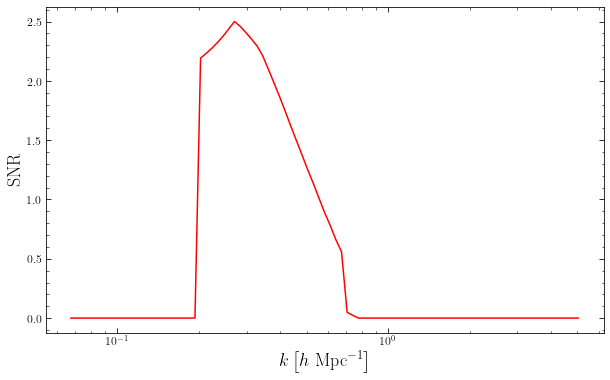

In [38]:
plt.figure(figsize = (10, 6))
plt.plot(ks, np.abs(x_power_spec(ks)) / cross_noise, color = 'red')
plt.xscale('log')
plt.ylabel('SNR', fontsize = 18)
plt.xlabel(r'$k \left[h \ {\rm Mpc}^{-1} \right]$', fontsize = 18)
plt.show()
#plt.savefig('xps_SNR_mod_7.png')

## 21cmSense

### Pickle 21cmSense Objects 

In [47]:
config_files = glob.glob('../sense_configs/hera_sense_*')
config_files.sort()

overwrite = False

for f in config_files:
    """Save objects out for use later
    """
    base = os.path.basename(f)
    pkl_name = os.path.splitext(base)[0]
    if not os.path.exists(pkl_name + '.pkl') or overwrite:
        sensitivity = sense.PowerSpectrum.from_yaml(f)
        with open(pkl_name + '.pkl', 'wb') as pfile:
            pickle.dump(sensitivity, pfile)

In [48]:
pkl_files = glob.glob('hera_sense_*.pkl')
pkl_files.sort()

overwrite = False

for i, p in enumerate(pkl_files):
    
    base = os.path.splitext(p)[0]
    if not os.path.exists(base + '.npy') or overwrite:
        # Calculate Noise
        with open(p, 'rb') as pfile:
            sensitivity = pickle.load(pfile)

        sample = sensitivity.calculate_sensitivity_1d(sample = True, thermal = True)
        ks = np.logspace(np.log10(1.2 * sensitivity.k_min.value), np.log10(0.9 * sensitivity.k_max.value), 115)
        err_21cm = interp1d(sensitivity.k1d, sample, kind = 'linear')
        noise = err_21cm(ks)
        noise[np.isnan(noise)] = 1e5
        np.save(base + '.npy', noise)

## Big Sensitivity Plot 
### 21cm - HERA

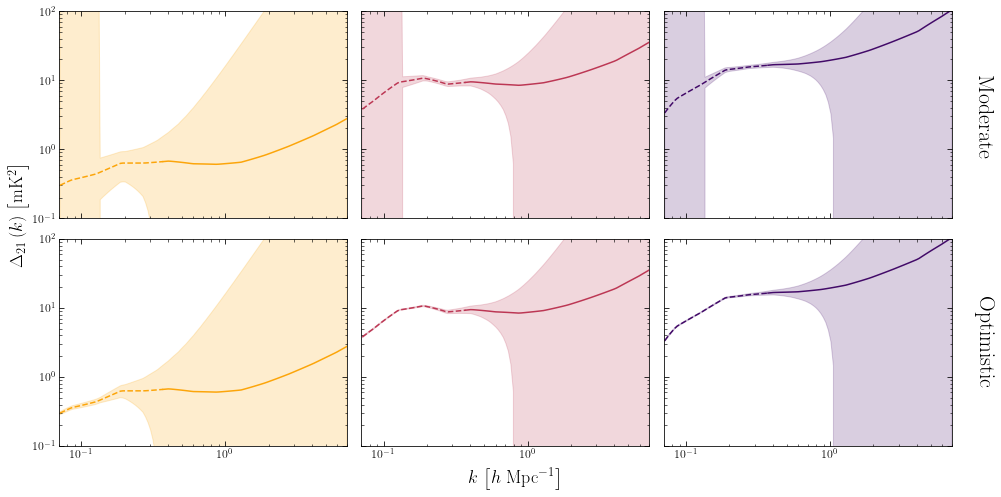

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharey = True, sharex = True)

axs = ax.ravel()

colors = plt.cm.inferno(np.linspace(0.2, 0.8, 3))[::-1]

pkl_files = glob.glob('hera_sense_*.pkl')
pkl_files.sort()

for i, ax_i in enumerate(axs):
    
    with open(pkl_files[i], 'rb') as pfile:
        sensitivity = pickle.load(pfile)
    
    base = os.path.splitext(pkl_files[i])[0]
    noise = np.load(base + '.npy')
    
    ks = np.logspace(np.log10(1.2 * sensitivity.k_min.value), np.log10(0.9 * sensitivity.k_max.value), 115)
    
    ax_i.plot(ks[:42], sensitivity.p21(ks[:42]), color = colors[i % 3], linestyle = '--')
    ax_i.plot(ks[41:], sensitivity.p21(ks[41:]), color = colors[i % 3], linestyle = '-')
    ax_i.fill_between(ks, sensitivity.p21(ks).value - noise,
                     sensitivity.p21(ks).value + noise, alpha = 0.2, color = colors[i % 3])
    ax_i.set_xscale('log')
    ax_i.set_yscale('log')
    ax_i.set_xlim([0.07, 7])
    ax_i.set_ylim([0.1, 1e2])
    
fig.text(0.48, 0.06, r'$k$ $\left[h \ {\rm Mpc}^{-1} \right]$', fontsize = 18)
fig.text(0.08, 0.44, r'$\Delta_{21} \left( k \right)$ $\left[\rm mK^2 \right]$', rotation = 90, fontsize = 18)

fig.text(0.92, 0.63, r'Moderate', fontsize = 22, rotation = 270)
fig.text(0.92, 0.23, r'Optimistic', fontsize = 22, rotation = 270)
#fig.tight_layout()   
plt.subplots_adjust(wspace = 0.05, hspace = 0.1)
plt.savefig('21cm_errorbars.png', dpi = 500, bbox_inches = 'tight')

### Ly$\alpha$ - SPHEREx

### 21cm-Ly$\alpha$ (HERA-SPHEREx)